## Installing Tools

In [ ]:
import sys, os, distutils.core
# Properly install detectron2.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [2]:
!git clone https://github.com/facebookresearch/detectron2.git

fatal: destination path 'detectron2' already exists and is not an empty directory.


## Importing Tools

In [197]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import torch

import tensorflow as tf
from keras.models import Model, load_model

# import some common libraries
import numpy as np
import os, json, cv2, random
import glob
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

import PIL


2023-01-27 00:26:26.065250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 00:26:27.684495: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cescollino/Workspace/abd-skin-segmentation/venv/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-27 00:26:27.684623: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cescollino/Workspace/abd

In [198]:
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

print("GPU", torch.cuda.is_available())

print('---------TENSORFLOW-----------------')
print(tf.__version__)
print("Available: ", tf.config.list_physical_devices())

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:45:30_PST_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0
torch:  1.13 ; cuda:  cu117
detectron2: 0.6
GPU True
---------TENSORFLOW-----------------
2.11.0
Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-27 00:27:19.639968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 00:27:20.034040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 00:27:20.034230: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Get SyRIP Data

In [5]:
!wget -r -np -A "train0*.jpg" https://coe.northeastern.edu/Research/AClab/SyRIP/images/train_infant/ --no-host-directories -Q

wget: option requires an argument -- 'Q'
wget: --quota: Invalid byte value ‘https://coe.northeastern.edu/Research/AClab/SyRIP/images/train_infant/’


In [6]:
## Use only for direct terminal access
#!pip install colab-xterm
#%load_ext colabxterm
#%xterm

In [7]:
!echo 'current working directory :' && pwd
%cd Research/AClab/SyRIP/images/train_infant/
!echo "Real Images match the starting string train0*.jpg" && ls | head -n 5 && ls | tail -n 5 && echo 'current working directory :' && pwd
# 500 images total

current working directory :
/home/cescollino/Workspace/abd-skin-segmentation
/home/cescollino/Workspace/abd-skin-segmentation/Research/AClab/SyRIP/images/train_infant
Real Images match the starting string train0*.jpg
train00001.jpg
train00002.jpg
train00003.jpg
train00004.jpg
train00005.jpg
train00496.jpg
train00497.jpg
train00498.jpg
train00499.jpg
train00500.jpg
current working directory :
/home/cescollino/Workspace/abd-skin-segmentation/Research/AClab/SyRIP/images/train_infant


# Data preprocessing


## Image Histograms

In [8]:
def describeimage(image, bins=256):
    plt.rcParams["figure.figsize"] = (20,5)
    plt.imshow(image)
    #plt.set_cmap('gist_gray')
    #plt.colorbar()
    plt.show()
    #print("The shape of this image is",np.shape(image))
    #print("The minimum value of this image is",np.min(image))
    #print("The maximum value of this image is",np.max(image))
    #print("The mean value of this image is",np.mean(image))
    
    chans = cv2.split(image)
    colors = ("b", "g", "r")
    plt.rcParams["figure.figsize"] = (20,5)
    plt.figure()
    plt.title("'Flattened' Color Histogram")
    plt.xlabel("Bins Excluding 0 (Padding)")
    plt.ylabel("# of Pixels")
    # loop over the image channels
    for (chan, color) in zip(chans, colors):
      # create a histogram for the current channel and plot it
      hist = cv2.calcHist([chan], [0], None, [256], [1, 256])
      plt.plot(hist, color=color)
      plt.xlim([0, 256])
    #plt.xlim(0,1)
    plt.show()

## Padding

In [94]:
realbabies = glob.glob("./train0*.jpg")
print("dataset lenght:", len(realbabies))
IMG_WIDTH = 512
print("IMG_WIDTH",IMG_WIDTH)

IMG_CHANNELS = 3
print("IMG_CHANNELS",IMG_CHANNELS)

X_BB = np.zeros((len(realbabies), IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

def padding(im, desired_size:int):
  
  old_size = im.shape[:2] # old_size is in (height, width) format
  #print(old_size)
  ratio = float(desired_size)/max(old_size)
  new_size = tuple([int(x*ratio) for x in old_size])
  im = cv2.resize(im, (new_size[1], new_size[0]))
  delta_w = desired_size - new_size[1]
  delta_h = desired_size - new_size[0]
  top, bottom = delta_h//2, delta_h-(delta_h//2)
  left, right = delta_w//2, delta_w-(delta_w//2)
  color = [0, 0, 0]
  new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
  
  return new_im


for n, id_ in tqdm(enumerate(realbabies), total=len(realbabies)):
    img = imread(id_)[:,:,:IMG_CHANNELS]
    if np.shape(img)[2] != 3: #verify channels
      print(np.shape(img)[2],n)
    #print("b4 padding",np.shape(img))
    img = padding(img,IMG_WIDTH)
    #print("after padding",np.shape(img))
    img = resize(img, (IMG_WIDTH, IMG_WIDTH), mode='constant', preserve_range=True)
    X_BB[n] = img


dataset lenght: 500
IMG_WIDTH 512
IMG_CHANNELS 3


  0%|          | 0/500 [00:00<?, ?it/s]

## Example images from test np array

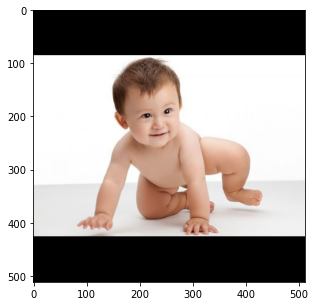

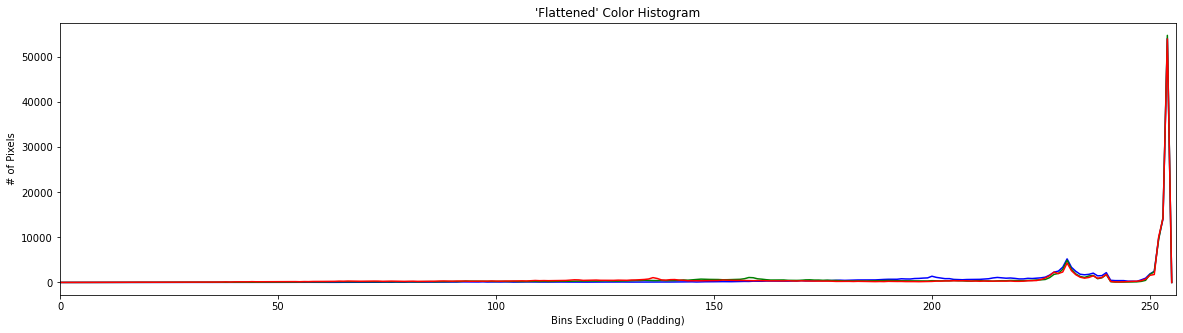

In [10]:
ix = random.randint(0, np.shape(X_BB)[0])
describeimage(X_BB[ix])


## U-NET skin segmentation

In [200]:
## Intersection-over-Union (IoU) metric, can be tracked instead of the accuracy during training

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [206]:
!pwd
model = load_model('/home/cescollino/Workspace/abd-skin-segmentation/UNET/your_model_name.h5', custom_objects={'mean_iou': mean_iou})

/home/cescollino/Workspace/abd-skin-segmentation/Research/AClab/SyRIP/images/train_infant


2023-01-27 00:29:26.927753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 00:29:26.928867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 00:29:26.929209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 00:29:26.929482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

## MRCNN Person Segm

{0: u'__background__',
 1: u'**person**',
 2: u'bicycle',
 ...
 79: u'hair drier',
 80: u'toothbrush'}

## Only Segmenting Person Class
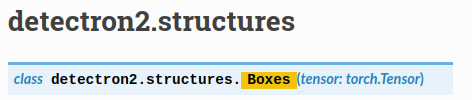
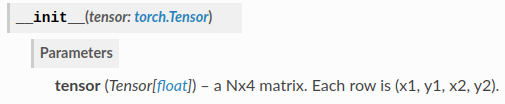

In [66]:
def onlykeeppersonclass(outputs, cuda_available:bool):
  cls = outputs['instances'].pred_classes
  scores = outputs["instances"].scores
  masks = outputs['instances'].pred_masks
  boxes = outputs['instances'].pred_boxes
  print(type(outputs['instances']))
  print(boxes.tensor.size())
  raise(IndexError('wait!'))
  # remove all other classes which are not person(index:0)
  indx_to_remove = (cls != 0).nonzero().flatten().tolist()
  
  # delete corresponding arrays
  cls = np.delete(cls.cpu().numpy(), indx_to_remove)
  scores = np.delete(scores.cpu().numpy(), indx_to_remove)
  masks = np.delete(masks.cpu().numpy(), indx_to_remove, axis=0)
  boxes = torch.cat((boxes.tensor[:],boxes.tensor[:]), axis = 1)
  #t = torch.cat((t[:,:3], t[:,4:]), axis = 1)))
  
  if cuda_available:
      
    # convert back to tensor and move to cuda
    cls = torch.tensor(cls).to('cuda:0')
    scores = torch.tensor(scores).to('cuda:0')
    masks = torch.tensor(masks).to('cuda:0')
    boxes = torch.tensor(boxes).to('cuda:0')
  else:
    cls = torch.tensor(cls)
    scores = torch.tensor(scores)
    masks = torch.tensor(masks)
    boxes = torch.tensor(boxes)

  # if not interested in boxes
  #outputs['instances'].remove('pred_boxes')

  # create new instance obj and set its fields
  obj = detectron2.structures.Instances(image_size=(IMG_WIDTH, IMG_WIDTH))
  obj.set('pred_classes', cls)
  obj.set('scores', scores)
  obj.set('pred_masks', masks)
  obj.set('pred_boxes', boxes)
  
  return obj

## Instance Segmentation Inference

[01/27 01:05:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x/139653917/model_final_2d9806.pkl ...


  0%|          | 0/500 [00:00<?, ?it/s]

[ 49 133 472 393]
crop_mask shape:: (1, 512, 512)
(260, 423, 3)
(128, 128, 3)


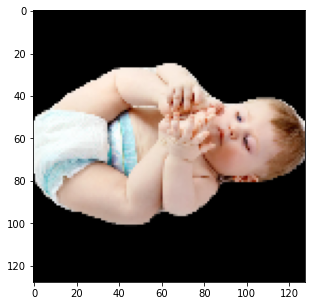

1/1 [==============================] - 0s 17ms/step


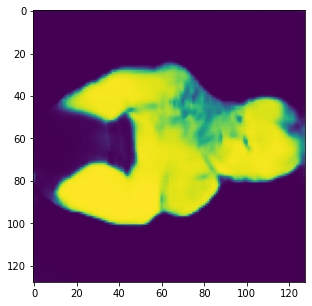

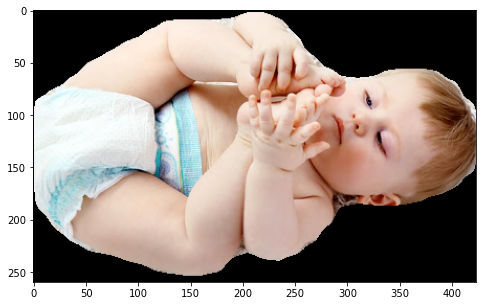

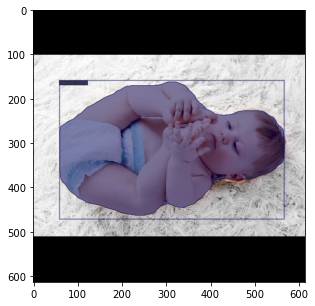

[144 237 381 344]
crop_mask shape:: (1, 512, 512)
(107, 237, 3)
(128, 128, 3)


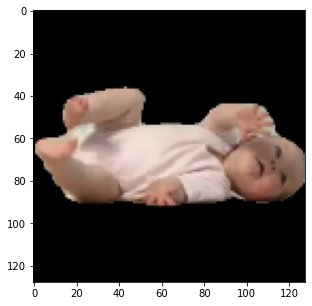

1/1 [==============================] - 0s 16ms/step


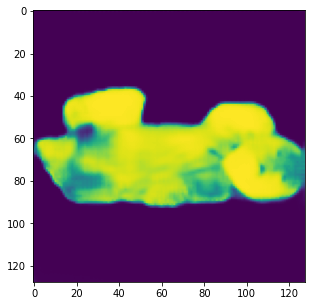

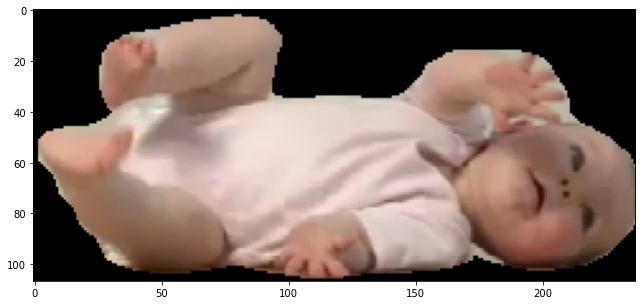

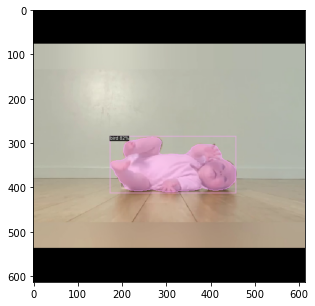

[179 153 308 285]
crop_mask shape:: (4, 512, 512)


ValueError: operands could not be broadcast together with shapes (132,129,3) (132,129,3,4) 

In [219]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cuda_available = torch.cuda.is_available()
if cuda_available == False:
  print("GPU not available")
  cfg.MODEL.DEVICE='cpu'

predictor = DefaultPredictor(cfg)

for i in tqdm(X_BB, total = len(X_BB)):
  outputs = predictor(i)
  
  #outputs = onlykeeppersonclass(outputs, cuda_available)
  
  v = Visualizer(i[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  
  out = v.draw_instance_predictions(outputs['instances'].to('cpu'))
  
  img = out.get_image()
  
  
  #print(outputs["instances"])
  
  for n,bbox in enumerate(iter(list(outputs["instances"].pred_boxes))):
    bbox = bbox.detach().cpu().numpy().astype(int)
    print(bbox)
    crop_img = out.get_image()[:, :, ::-1]
    crop_img = i[bbox[1]:bbox[3],bbox[0]:bbox[2]]
    
    ##Segment Person
    crop_mask  = outputs["instances"].pred_masks.detach().cpu().numpy()
    print('crop_mask shape::',np.shape(crop_mask))
    crop_mask = np.moveaxis(crop_mask,0,2)
    crop_mask = crop_mask[bbox[1]:bbox[3],bbox[0]:bbox[2]]
    crop_mask = np.stack([crop_mask,crop_mask,crop_mask],axis=2)
    crop_mask = np.squeeze(crop_mask)
    crop_mask = np.array(crop_mask, dtype=np.uint8)
    
    crop_result = crop_img*crop_mask
    
    ## Segment Skin
    print(np.shape(crop_result))
    resized = padding(crop_result, np.max(np.shape(crop_result)))
    resized = cv2.resize(resized,(128,128))
    print(np.shape(resized))
    plt.imshow(resized)
    plt.show()
  
    skin = model.predict(np.stack(([resized,resized]))) ##workaround, messy
    skin = skin[0]
    plt.imshow(skin)
    plt.show()
    plt.imshow(crop_result)
    plt.show()
  
  
  plt.imshow(out.get_image()[:, :, ::-1])
  #plt.set_cmap('gist_gray')
  #plt.colorbar()
  plt.show()
    

## Inference Panoptic Segmentation Data

[01/26 21:57:21 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


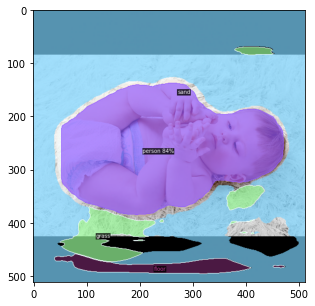

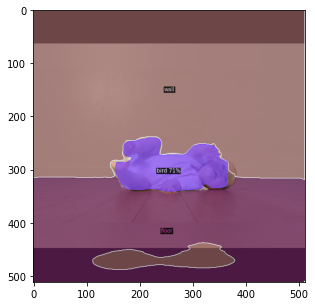

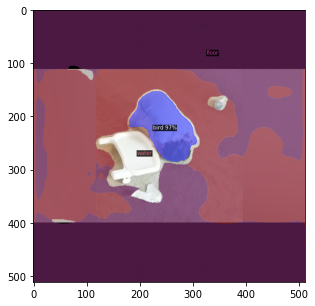

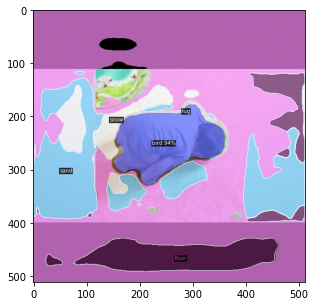

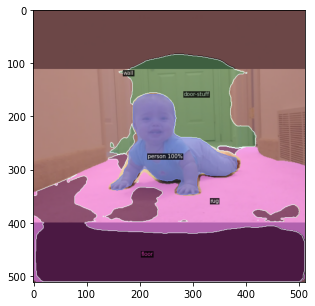

ValueError: RGBA values should be within 0-1 range

In [105]:
# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)

for i in X_BB:
  panoptic_seg, segments_info = predictor(i)["panoptic_seg"]
  panoptic_seg[panoptic_seg < 0] = 0
  v = Visualizer(i[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
  out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
  #image = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
  plt.imshow(out.get_image()[:, :, ::-1])
  plt.show()

## Inference with a keypoint detection model

In [ ]:
# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
for i in X_BB:
  outputs = predictor(i)
    
  v = Visualizer(i[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  describeimage(out.get_image()[:, :, ::-1])

## Inference with DensePose

In [ ]:
!pip install -v git+https://github.com/facebookresearch/detectron2@main#subdirectory=projects/DensePose


Using pip 22.0.4 from /usr/local/lib/python3.8/dist-packages/pip (python 3.8)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2 (to revision main) to /tmp/pip-req-build-pcnmdxef
  Running command git version
  git version 2.25.1
  Running command git clone --filter=blob:none https://github.com/facebookresearch/detectron2 /tmp/pip-req-build-pcnmdxef
  Cloning into '/tmp/pip-req-build-pcnmdxef'...
  Running command git show-ref main
  58e472e076a5d861fdcf773d9254a3664e045bf8 refs/heads/main
  58e472e076a5d861fdcf773d9254a3664e045bf8 refs/remotes/origin/main
  Running command git symbolic-ref -q HEAD
  refs/heads/main
  Resolved https://github.com/facebookresearch/detectron2 to commit 58e472e076a5d861fdcf773d9254a3664e045bf8
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-jejfmi82/detectron2_densepose.egg-info
  writing /tmp/pip-pip-egg-i

In [ ]:
!wget https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_101_FPN_DL_s1x/165712116/model_final_844d15.pkl 

--2023-01-24 16:36:29--  https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_101_FPN_DL_s1x/165712116/model_final_844d15.pkl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 340915660 (325M) [binary/octet-stream]
Saving to: ‘model_final_844d15.pkl’

model_final_844d15. 100%[===================>] 325.12M  25.6MB/s    in 14s     

2023-01-24 16:36:43 (24.0 MB/s) - ‘model_final_844d15.pkl’ saved [340915660/340915660]



In [ ]:
!python /content/detectron2/projects/DensePose/apply_net.py show /content/detectron2/projects/DensePose/configs/densepose_rcnn_R_101_FPN_DL_s1x.yaml ./model_final_844d15.pkl input.jpg dp_contour,bbox --output image_densepose_contour.png


/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/detectron2/projects/DensePose/densepose/vis/densepose_results.py:133: UserWarning: The following kwargs were not used by contour: 'cfg', 'texture_atlas', 'texture_atlases_dict'
  plt.contour(u, self.levels, extent=extent, **self.plot_args)
/content/detectron2/projects/DensePose/densepose/vis/densepose_results.py:134: UserWarning: The following kwargs were not used by contour: 'cfg', 'texture_atlas', 'texture_atlases_dict'
  plt.contour(v, self.levels, extent=extent, **self.plot_args)


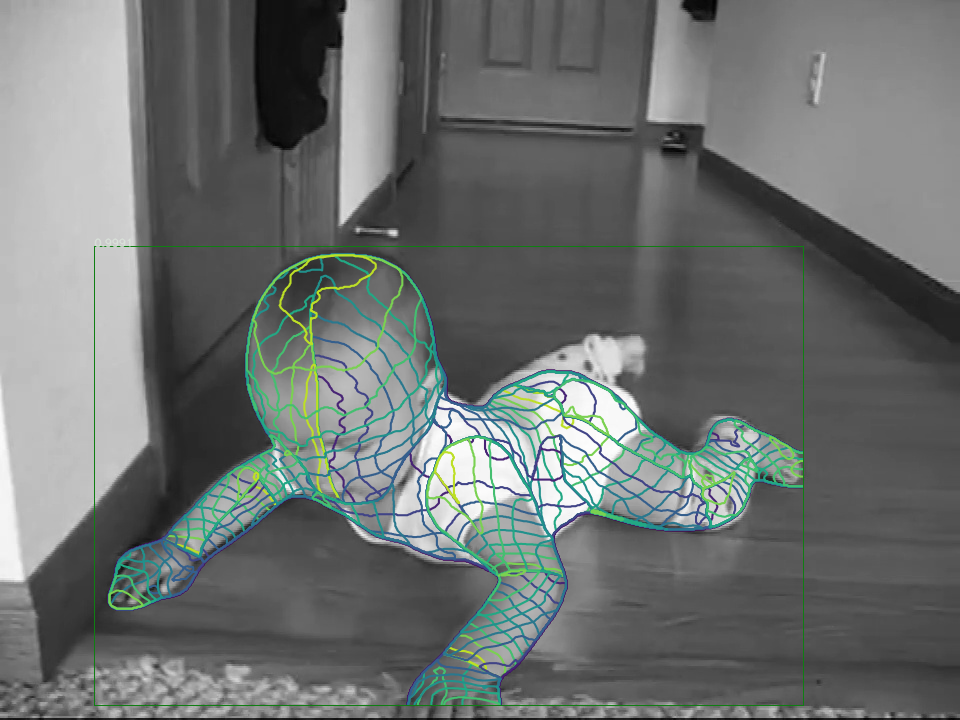

In [ ]:
a= cv2.imread("image_densepose_contour.0001.png")
cv2_imshow(a)